# CF 2.4 - Fundamentals of Visualization Libraries - Seaborn

### The following script looks into some of the questions originally posed when outlining the project plan, namely:

- What are the most used start / end points?
- How does weather (temp) impact bike usage)
- What does user distribution look like?

### The script is broken into multiple sections:

- Library & data importing - regarding data importing, at multiple times my computer seemed to have issues tackling some of the wrangling steps and as such there are instances where I have exported dfs to use as a backup in case JupyterLabs python/timed out.
- Data checks and general wrangling
- Pre-processing for Q1/Viz1 + Visualizations
- Pre-processing for Q2/Viz2 + Visualizations
- Pre-processing for Q3/Viz3 + Visualizations
- Pre-processing for Q4/Viz4 + Visualizations

### Step 1: Library Importing & Data Importing

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime as dt
import seaborn as sns
import os
import swifter

C:\Users\mojos\anaconda3\envs\venv_nycbikes\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sns.set_theme(style = "whitegrid", palette = "Blues_r")

In [3]:
df = pd.read_csv('nyc_data_wtrips.csv', index_col = 0)

C:\Users\mojos\AppData\Local\Temp\ipykernel_8752\486106831.py:1: DtypeWarning: Columns (6,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('nyc_data_wtrips.csv', index_col = 0)


### Step 2: Data Checks

In [4]:
df.shape

(30689921, 19)

In [7]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,start_time,date,avgTemp,bike_rides_daily,_merge,trip_time
0,68FDAB9B6656A4DF,classic_bike,2022-01-01 05:11:08,2022-01-01 05:15:25,W 21 St & 6 Ave,6140.05,W 11 St & 6 Ave,5914.03,40.741740,-73.994156,40.735324,-73.998004,member,2022-01-01 05:11:08,2022-01-01,11.6,20895,both,4.0
1,91C955306D2CF8A6,electric_bike,2022-01-01 20:54:00,2022-01-01 21:06:39,Bedford Ave & Nassau Ave,5550.05,Sharon St & Olive St,5323.05,40.723117,-73.952123,40.715353,-73.938560,member,2022-01-01 20:54:00,2022-01-01,11.6,20895,both,13.0
2,B379B77AEB677F2A,electric_bike,2022-01-01 15:48:06,2022-01-01 16:44:21,Central Park W & W 91 St,7453.01,5 Ave & E 87 St,7323.09,40.788665,-73.966801,40.782323,-73.959875,casual,2022-01-01 15:48:06,2022-01-01,11.6,20895,both,56.0
3,1F1368CC1EEDA296,electric_bike,2022-01-01 02:32:52,2022-01-01 02:44:51,West End Ave & W 78 St,7340.07,W 44 St & 11 Ave,6756.05,40.783786,-73.981687,40.762009,-73.996975,casual,2022-01-01 02:32:52,2022-01-01,11.6,20895,both,12.0
4,9FE4ABC81014D80D,electric_bike,2022-01-01 17:43:17,2022-01-01 17:52:31,Lawrence St & Willoughby St,4596.09,Carroll St & 6 Ave,4019.06,40.692362,-73.986317,40.674089,-73.978728,member,2022-01-01 17:43:17,2022-01-01,11.6,20895,both,9.0


In [8]:
df.dtypes

ride_id                object
rideable_type          object
started_at             object
ended_at               object
start_station_name     object
start_station_id       object
end_station_name       object
end_station_id         object
start_lat             float64
start_lng             float64
end_lat               float64
end_lng               float64
member_casual          object
start_time             object
date                   object
avgTemp               float64
bike_rides_daily        int64
_merge                 object
trip_time             float64
dtype: object

In [9]:
df.isnull().sum()

ride_id                   0
rideable_type             0
started_at                0
ended_at                  0
start_station_name       50
start_station_id         50
end_station_name      71773
end_station_id        71773
start_lat                 0
start_lng                 0
end_lat               37516
end_lng               37516
member_casual             0
start_time                0
date                      0
avgTemp                   0
bike_rides_daily          0
_merge                    0
trip_time                 0
dtype: int64

### Step 2.2: Wrangling

#### There are only missing values in the station details (Names / Ids, and coordinates) - I'm not worried about station details missing as based off the citibike website and other bike sharing apps, not all bike types have to be docked at the end of each ride. What is more worrying are the ones with no end coordinates.

#### My gut instinct indicates that these values which have no end station OR end_lat are scenarios where the bikes may not have been returned correctly such as human error when logging off/docking or technical/hardware errors with the GPS. I'll create a flag for these marked as 'unreturned'

In [10]:
# generation a boolean
df['unfinished_ride'] = df['end_lat'].isna().astype(int)
df['unfinished_ride'].value_counts()

unfinished_ride
0    30652405
1       37516
Name: count, dtype: int64

#### qty of 'unfinished rides' marked as a 1 mirrors the qty of isnull results for that column. I'll subset these in case they are needed for later use.

In [11]:
#Generating a 'dostance travelled' value which is based of the as the corw flies distance between start and end coordinates

#additional Geopy importing
from geopy.geocoders import Nominatim
import geopy.distance
geolocator = Nominatim(user_agent='DistanceCalculator')

# Test run between coordinates on first row:
#Performing a test of geo.distance function in isolation referencing the first lat/long position of the DF
coord1 = (40.741740, 73.994156) ## Value represents first row in DF
coord2 = (40.735324, 73.998004) 
geopy.distance.geodesic(coord1, coord2).km

0.7831248793242954

In [12]:
#creating a subset of rides which were completed and applying the distance calculation to it, iterating through each row:
df_finished_ride = df.loc[df['unfinished_ride']==0]

#due to df size, I'm still having issues with hardware - creating a smaller df which will then be merged onto the main df after the function has been run.
columns = ['ride_id','start_lat','start_lng','end_lat','end_lng']
df_concise = df_finished_ride[columns]
df_concise.shape

(30652405, 5)

In [13]:
def get_dist(row):
    start_coord = (row['start_lat'], row['start_lng'])
    end_coord = (row['end_lat'], row['end_lng'])
    return geopy.distance.geodesic(start_coord, end_coord).km


# Apply the function to each row
df_concise["trip_dist_km"] = df_concise.swifter.apply(get_dist, axis=1)

Pandas Apply: 100%|████████████████████████████████████████████████████| 30652405/30652405 [1:56:51<00:00, 4371.83it/s]
C:\Users\mojos\AppData\Local\Temp\ipykernel_5140\1975904171.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_concise["trip_dist_km"] = df_concise.swifter.apply(get_dist, axis=1)


#### Geopy Distance calculation took almost 2hrs to complete. Data exported for the sake of making running through this script more efficient. Because this is only a 1 off ex, I'm not currently worried with increasing the efficiency of this operation.

In [16]:
df_concise.to_csv('Ride_id_with_Distance.csv')

In [5]:
df_concise = pd.read_csv('Ride_id_with_Distance.csv')

In [6]:
#After re-importing the data I need to merge the relevant values back onto the main DF - this smaller DF should hopefully speed up the merge function
df_selected = df_concise[['ride_id','trip_dist_km']]

In [7]:
df = df.drop(columns = '_merge')

In [8]:
df = pd.merge(df,df_selected,on ='ride_id', how='left', indicator = True)

In [28]:
#Checking merge output 1
df.head()

,Unnamed: 0,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,...,end_lng,member_casual,start_time,date,avgTemp,bike_rides_daily,trip_time,trip_dist_km,_merge,value
0,0,68FDAB9B6656A4DF,classic_bike,2022-01-01 05:11:08,2022-01-01 05:15:25,W 21 St & 6 Ave,6140.05,W 11 St & 6 Ave,5914.03,40.741740,...,-73.998004,member,2022-01-01 05:11:08,2022-01-01,11.6,20895,4.0,0.783088,both,1
1,1,91C955306D2CF8A6,electric_bike,2022-01-01 20:54:00,2022-01-01 21:06:39,Bedford Ave & Nassau Ave,5550.05,Sharon St & Olive St,5323.05,40.723117,...,-73.938560,member,2022-01-01 20:54:00,2022-01-01,11.6,20895,13.0,1.434057,both,1
2,2,B379B77AEB677F2A,electric_bike,2022-01-01 15:48:06,2022-01-01 16:44:21,Central Park W & W 91 St,7453.01,5 Ave & E 87 St,7323.09,40.788665,...,-73.959875,casual,2022-01-01 15:48:06,2022-01-01,11.6,20895,56.0,0.915302,both,1
3,3,1F1368CC1EEDA296,electric_bike,2022-01-01 02:32:52,2022-01-01 02:44:51,West End Ave & W 78 St,7340.07,W 44 St & 11 Ave,6756.05,40.783786,...,-73.996975,casual,2022-01-01 02:32:52,2022-01-01,11.6,20895,12.0,2.741188,both,1
4,4,9FE4ABC81014D80D,electric_bike,2022-01-01 17:43:17,2022-01-01 17:52:31,Lawrence St & Willoughby St,4596.09,Carroll St & 6 Ave,4019.06,40.692362,...,-73.978728,member,2022-01-01 17:43:17,2022-01-01,11.6,20895,9.0,2.128204,both,1


In [18]:
#Checking merge output 2
df['_merge'].value_counts()

_merge
both          30652405
left_only        37516
right_only           0
Name: count, dtype: int64

In [10]:
#Value added to the df as a means of easier counting practices
df['value'] = 1

In [3]:
#This is the final data set for this ex. no additional wrangling steps expected on the main df
df.to_csv('nyc_bikes_dist.csv')

NameError: name 'df' is not defined

In [5]:
df = pd.read_csv('nyc_bikes_dist.csv')

C:\Users\mojos\AppData\Local\Temp\ipykernel_28116\2397089623.py:1: DtypeWarning: Columns (6,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('nyc_bikes_dist.csv')


In [8]:
df.shape

(30689921, 22)

In [61]:
df.head()

,Unnamed: 0,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,...,end_lng,member_casual,start_time,date,avgTemp,bike_rides_daily,trip_time,trip_dist_km,_merge,value
0,0,68FDAB9B6656A4DF,classic_bike,2022-01-01 05:11:08,2022-01-01 05:15:25,W 21 St & 6 Ave,6140.05,W 11 St & 6 Ave,5914.03,40.741740,...,-73.998004,member,2022-01-01 05:11:08,2022-01-01,11.6,20895,4.0,0.783088,both,1
1,1,91C955306D2CF8A6,electric_bike,2022-01-01 20:54:00,2022-01-01 21:06:39,Bedford Ave & Nassau Ave,5550.05,Sharon St & Olive St,5323.05,40.723117,...,-73.938560,member,2022-01-01 20:54:00,2022-01-01,11.6,20895,13.0,1.434057,both,1
2,2,B379B77AEB677F2A,electric_bike,2022-01-01 15:48:06,2022-01-01 16:44:21,Central Park W & W 91 St,7453.01,5 Ave & E 87 St,7323.09,40.788665,...,-73.959875,casual,2022-01-01 15:48:06,2022-01-01,11.6,20895,56.0,0.915302,both,1
3,3,1F1368CC1EEDA296,electric_bike,2022-01-01 02:32:52,2022-01-01 02:44:51,West End Ave & W 78 St,7340.07,W 44 St & 11 Ave,6756.05,40.783786,...,-73.996975,casual,2022-01-01 02:32:52,2022-01-01,11.6,20895,12.0,2.741188,both,1
4,4,9FE4ABC81014D80D,electric_bike,2022-01-01 17:43:17,2022-01-01 17:52:31,Lawrence St & Willoughby St,4596.09,Carroll St & 6 Ave,4019.06,40.692362,...,-73.978728,member,2022-01-01 17:43:17,2022-01-01,11.6,20895,9.0,2.128204,both,1


In [7]:
df.dtypes

Unnamed: 0              int64
ride_id                object
rideable_type          object
started_at             object
ended_at               object
start_station_name     object
start_station_id       object
end_station_name       object
end_station_id         object
start_lat             float64
start_lng             float64
end_lat               float64
end_lng               float64
member_casual          object
start_time             object
date                   object
avgTemp               float64
bike_rides_daily        int64
trip_time             float64
trip_dist_km          float64
_merge                 object
value                   int64
dtype: object

### Step 3: Pre-processing for Q1/Viz1 + Visualizations > BarCharts

In [36]:
df_t = df.groupby('start_station_name')['value'].count().reset_index()

In [37]:
top20 = df_t.nlargest(20, 'value')

In [38]:
bottom20 = df_t.nsmallest(20, 'value')

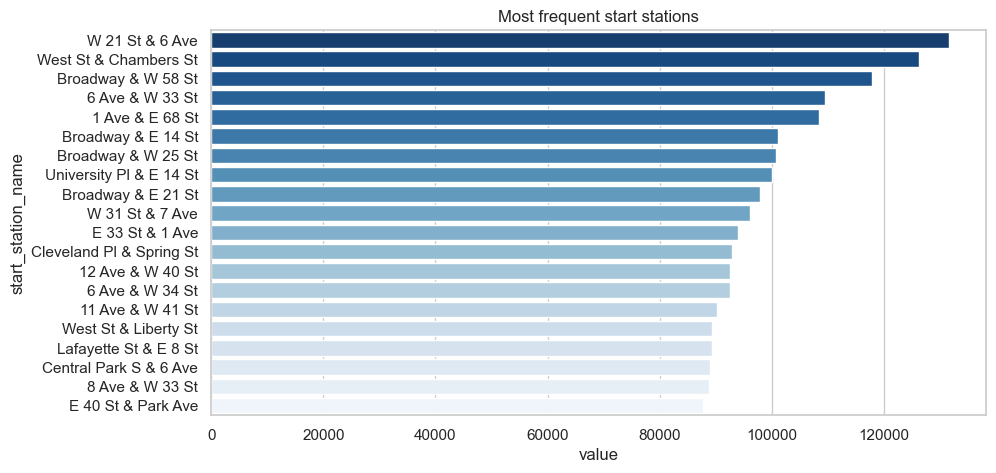

In [54]:
palette = sns.color_palette('Blues_r', n_colors=20)

plt.figure(figsize = (10,5))
sns.barplot(data = top20, x = 'value', y = 'start_station_name', palette=palette).set_title("Most frequent start stations")
plt.show()

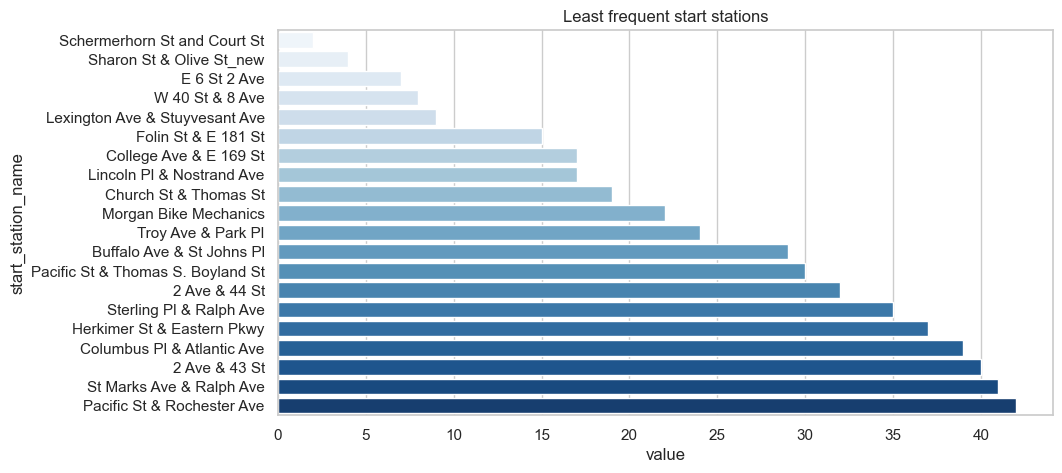

In [55]:
palette2 = sns.color_palette('Blues', n_colors=20)

plt.figure(figsize = (10,5))
sns.barplot(data = bottom20, x = 'value', y = 'start_station_name', palette=palette2).set_title("Least frequent start stations")
plt.show()

### Step 4: Pre-processing for Q2/Viz2 + Visualizations > Dual Axis Line Plot

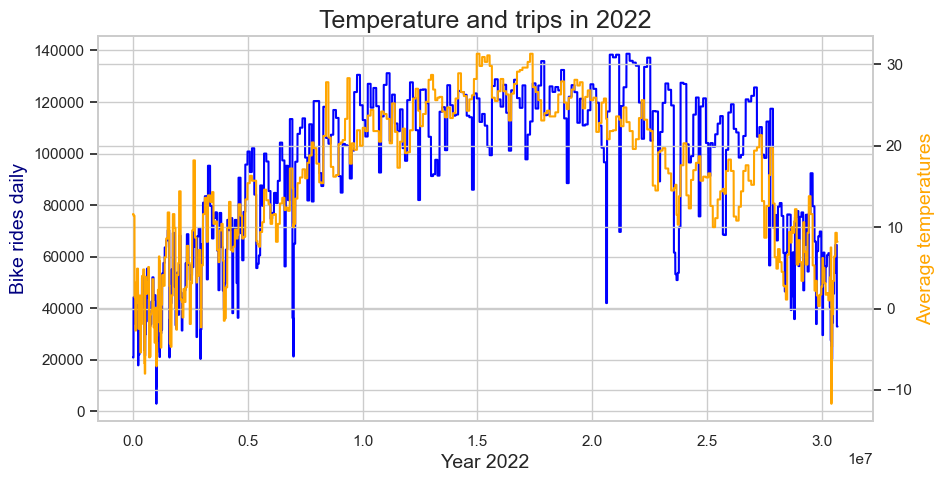

In [57]:
fig,ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data = df['bike_rides_daily'], color = "b")
ax.set_xlabel("Year 2022", fontsize = 14) # set x-axis label
ax.set_ylabel("Bike rides daily",color = "navy", fontsize = 14) # set y-axis label

ax2 = ax.twinx()
sns.lineplot(data = df['avgTemp'], color="orange", ax=ax2)
ax2.set_ylabel("Average temperatures", color = "orange",fontsize=14)
plt.title('Temperature and trips in 2022', fontsize = 18)
plt.show()

### Step 5: - Pre-processing for Q3/Viz3 > BoxPlots

In [23]:
#Based on a prior SNS plot generated, realistacally, any trip time over 100 seems to be an outlier - Reducing df to sub 200 for the sake of retaining 'trips'
df_limited = df[df['trip_time']<=200]
df_limited.shape

(30585109, 22)

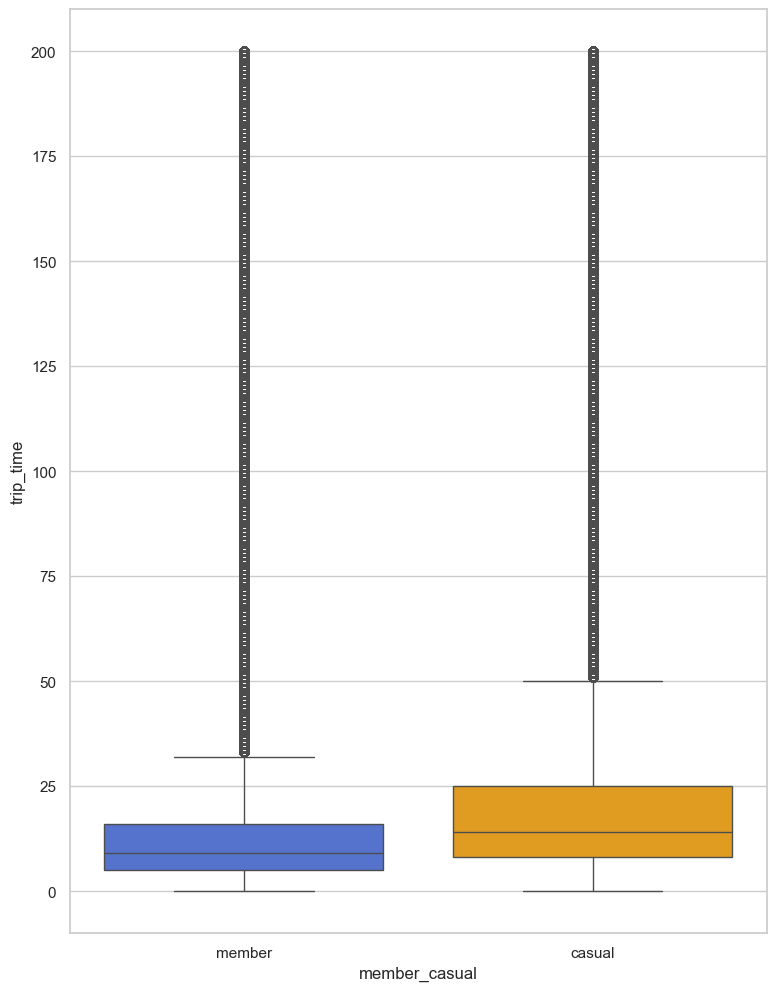

In [24]:
plt.figure(figsize=(9,12))
sns.boxplot(x = 'member_casual', y = 'trip_time', data = df_limited, palette = {'member': 'royalblue', 'casual': 'orange'})
plt.show()

#### The above boxplot may not be the most hollistic view of the data as it has been limited to only show trips under 200minutes in length. The reason for this was clarified previously. Pre-reduction, the scale was too difficult to make out the shape/values of the boxplots because we were instead greeted to a long string of 'outlier' values which represent an exceedingly long right-skewed tail.

#### by reducing the trip time threshold we can make a more informed analysis about how the two catagories (member/casual) compare. Both objects have a positive skew, where the median value is closer to the lower end of the box, indicating that riders of both groups do favor shorter journey times, however, the 'casual' does have a higher median value. This could simply be indicative of the grouping having less familiarity with NYC roads, less knowledge of available bike stations, or maybe just taking more casual journeys (i.e they are tourists using day passes). It's understandable that a regular member would be an NYC resident and they perhaps lean towards using CitiBike as a convenient form of public transit in lieu of taxis/subway which may be more costlier/less accessible.

#### I believe this is also backed up by the IQR and the maximum values, which again lean towards the 'casual' grouping having higher values for trip time durations. The IQR for 'members' is between approx. 5 & 15 (short journeys well under the 30min soft limit before additional per minute fees are incurred) where as 'casual' users hover between ~10 & 25.

#### I previously indicated that I think members perhaps have better geographical knowedlege and citibike rules knowledge because, whilst yes there are many outliers in both groups, the maximum value of the members group is around 30min, which shows an adherence to the 30min rule briefly mentioned where as the casual groups max value prior to outliers os 50min which supports the idea that this group is much more relaxed about the rules/don't now their geography as well OR may also hint that this group may be DAY PASS users, where the same limitations do not apply.

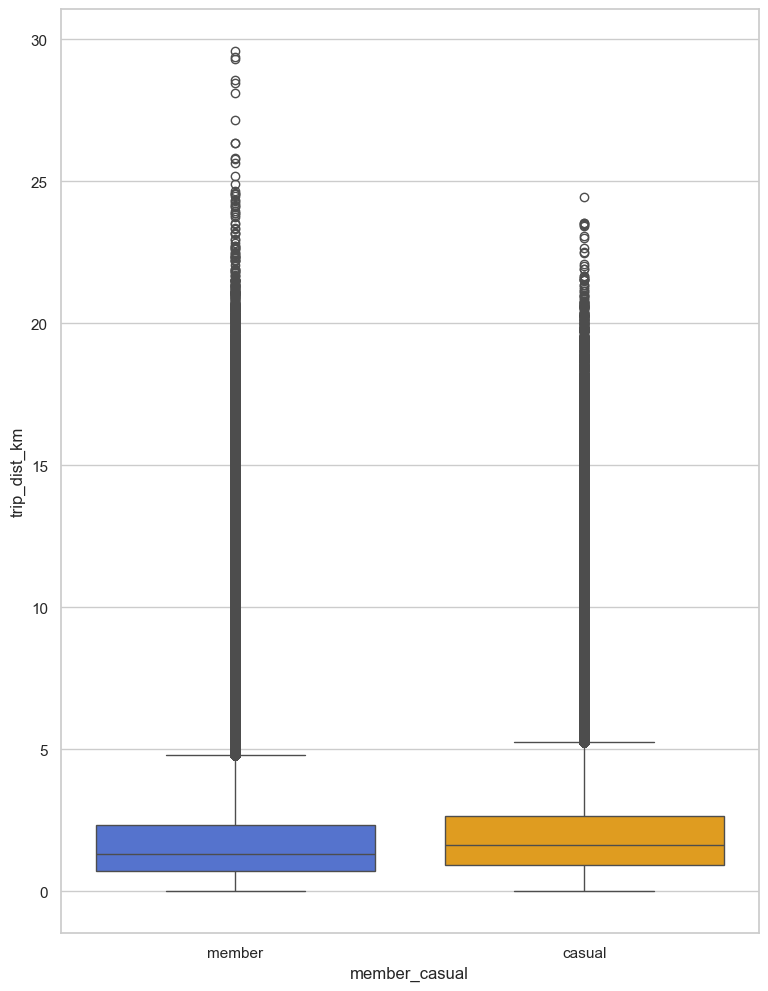

In [25]:
plt.figure(figsize=(9,12))
sns.boxplot(x = 'member_casual', y = 'trip_dist_km', data = df_limited, palette = {'member': 'royalblue', 'casual': 'orange'})
plt.show()

#### I've also reviewed the same catagory from the perspective of trip distance (Instead of duration) and generally (outliers not considered) the same thinking applies - Members tend to take smaller trips over their casual user counterparts.

### Step 6: Pre-processing for Q4/Viz4 + Visualizations

AttributeError: property 'fig' of 'FacetGrid' object has no setter

<Figure size 2000x1200 with 0 Axes>

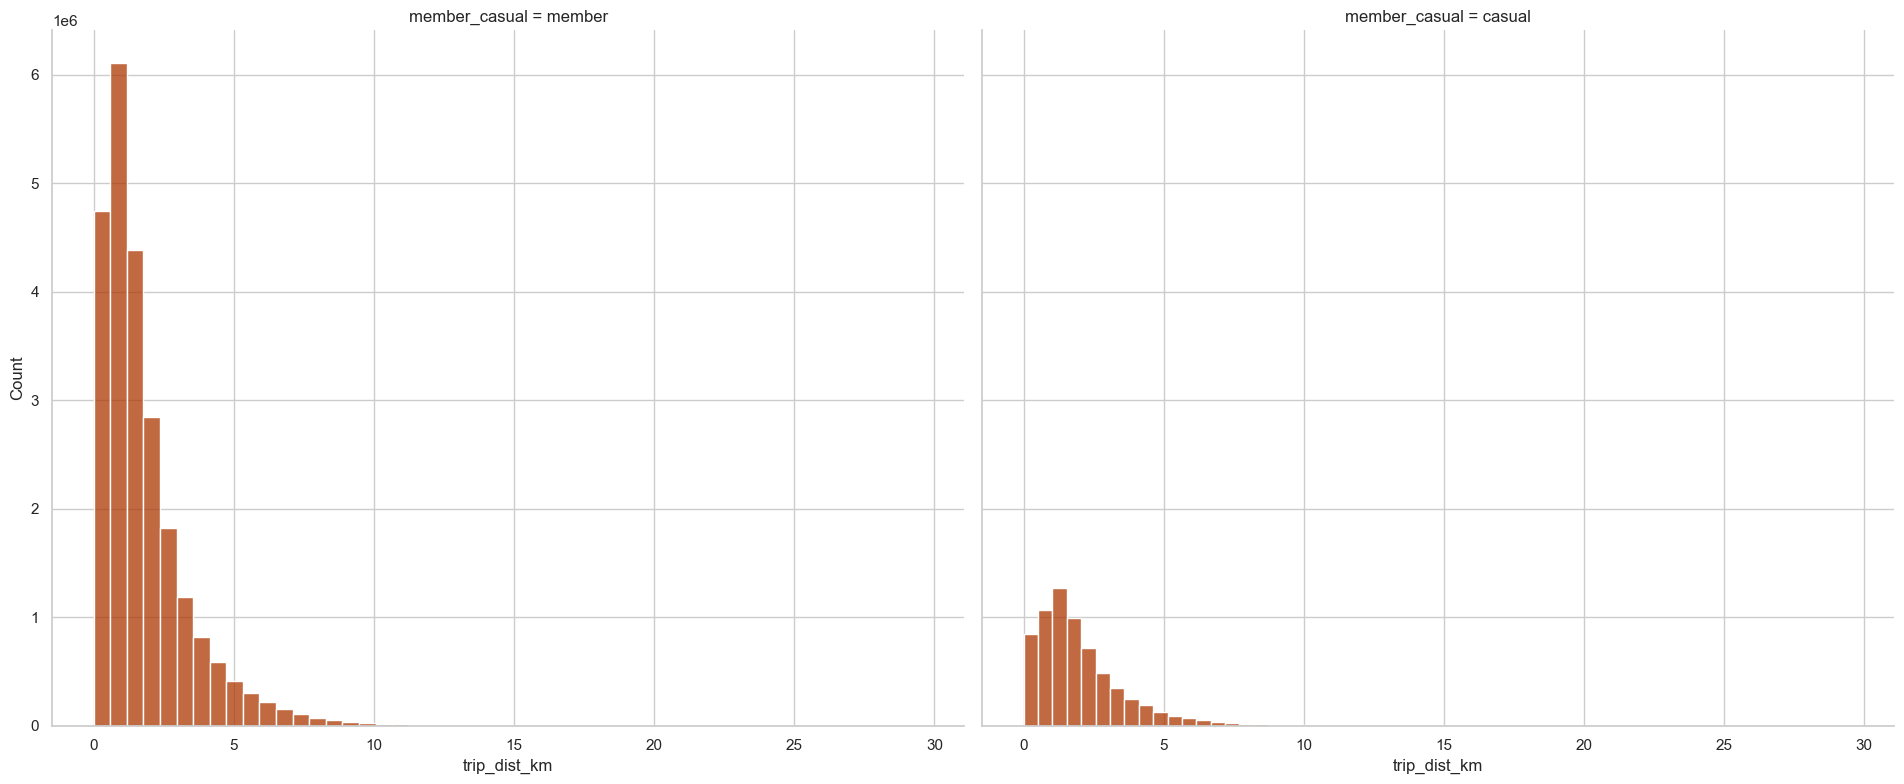

In [64]:
fig = plt.figure(figsize=(20, 12))
grid = sns.FacetGrid(df, col="member_casual", height=8, aspect=1.2)
grid.map(sns.histplot, "trip_dist_km", bins = 50)
grid.fig = fig
grid.fig.tight_layout()
plt.show()

#### Whilst there are similarities in the data displayed in this Facetgrid to the prior Boxplots there are a few diferences which improve legibility and the information displayed. The Boxplots above don't indicate the size of each cohort, which means that it's hard to get a hollistic overview of the comparisons being made. The FacetGrid (which shows frequency distribution) immediately showcases there is an incredibly large gap between the overal quantity of clients marked as 'casual' users instead of those registered as 'members'. This provides an additional perspective for us to then go back and view values such as trip time/distance/weather when cycling etc for each grouping. The members group are likely smaller because they are dedicated users who have Citibike as one of their predominant modes of transport for city commuting (come rain or shine) unlike casual users who may consist of any number of tourists or single day users.

#### The Facetgrid also provides further context on the outliers. It's hard to understand from the boxplots what the qty of outliers is because the tail which extends out past the whiskers is continuous as opposed to isolated, clearly defined data points. By viewing in a facetgrid, we are able to more easily visualize how negligible the values are relative to the overall dataset, as well as to the other cohort.